In [1]:
# Učitavanje potrebnih biblioteka

import pandas as pd
import numpy as np
import sklearn.preprocessing as sp
import sklearn.ensemble as se
import sklearn.metrics as sm
import sklearn.model_selection as sms
import xgboost as xgb
import matplotlib as plt
import matplotlib.pyplot as pyplt
import sklearn.feature_selection as fs
import random
import math

random.seed(42)


UČITAVANJE I KONSTRUKCIJA BAZA PODATAKA ZA TRENIRANJE MODELA STROJNOG UČENJA

In [2]:
# Učitavanje pojedinačnih baza za tumore i definicija varijable nadtipa za svaku

df_liver = pd.read_csv("Databases/Liver_GSE14520_U133A.csv")
df_liver["overtype"] = np.where(df_liver["type"] != "normal", "liver", "normal")

df_leukemia = pd.read_csv("Databases/Leukemia_GSE28497.csv")
df_leukemia["overtype"] = np.where(df_leukemia["type"] != "normal", "leukemia", "normal")

df_lung = pd.read_csv("Databases/Lung_GSE19804.csv")
df_lung["overtype"] = np.where(df_lung["type"] != "normal", "lung", "normal")
df_lung["type"].replace("tumoral", "lung_Ca", inplace=True)

df_renal = pd.read_csv("Databases/Renal_GSE53757.csv")
df_renal["overtype"] = np.where(df_renal["type"] != "normal", "renal", "normal")

df_brain = pd.read_csv("Databases/Brain_GSE50161.csv")
df_brain["overtype"] = np.where(df_brain["type"] != "normal", "brain", "normal")

# Spajanje pojedinačnih baza za tumore pri čemu se zadržavaju samo genetski biljezi zajednički cijeloj skupini

df1 = pd.concat([df_liver, df_leukemia], join="inner", axis=0)
df1 = pd.concat([df1, df_lung], join="inner", axis=0)
df1 = pd.concat([df1, df_renal], join="inner", axis=0)
df1 = pd.concat([df1, df_brain], join="inner", axis=0)

display(df1)

df_export = df1.copy()
df_export = df_export.drop("type", axis=1)
df_export = df_export.drop("overtype", axis=1)
df_export = df_export.drop("samples", axis=1)

display(df_export.columns)

df_export = pd.DataFrame(df_export.columns)
df_export.to_csv("microarray_features.txt")

# Razdvajanje baza na dvije kopije, jedna u kojoj je definiran nadtip i jedna u kojoj je definiran tip

df_overtype = df1.copy()
df_overtype = df_overtype.drop("type", axis=1)
df_overtype = df_overtype.drop("samples", axis=1)

df_type = df1.copy()
df_type = df_type.drop("overtype", axis=1)
df_type = df_type.drop("samples", axis=1)

display(df_type)
display(df_overtype)

,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,overtype
0,GSM362958.CEL.gz,HCC,6.801198,4.553189,6.787790,5.430893,3.250222,6.272688,3.413405,3.374910,...,10.398843,12.298551,12.270505,3.855588,3.148321,3.366087,3.199008,3.160388,3.366417,liver
1,GSM362959.CEL.gz,HCC,7.585956,4.193540,3.763183,6.003593,3.309387,6.291927,3.754777,3.587603,...,11.369919,12.867048,12.560433,4.016561,3.282867,3.541994,3.548680,3.460083,3.423348,liver
2,GSM362960.CEL.gz,HCC,7.803370,4.134075,3.433113,5.395057,3.476944,5.825713,3.505036,3.687333,...,10.416151,12.356337,11.888482,3.839367,3.598851,3.516791,3.484089,3.282626,3.512024,liver
3,GSM362964.CEL.gz,HCC,6.920840,4.000651,3.754500,5.645297,3.387530,6.470458,3.629249,3.577534,...,10.524836,12.006596,11.846195,3.867602,3.180472,3.309547,3.425501,3.166613,3.377499,liver
4,GSM362965.CEL.gz,HCC,6.556480,4.599010,4.066155,6.344537,3.372081,5.439280,3.762213,3.440714,...,10.775566,12.657182,12.573076,4.091440,3.306729,3.493704,3.205771,3.378567,3.392938,liver
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,959,pilocytic_astrocytoma,12.658228,8.843270,7.672655,9.125912,5.495477,8.603892,7.747514,5.828978,...,12.676080,14.124837,13.996436,4.913579,4.399176,3.878855,3.680103,4.726784,4.564637,brain
126,960,pilocytic_astrocytoma,12.812823,8.510550,8.729699,9.104402,3.967228,7.719089,7.092496,6.504812,...,12.403316,13.978009,13.812916,5.189600,4.912618,3.764800,3.664920,4.628355,4.761351,brain
127,961,pilocytic_astrocytoma,12.706991,8.795721,7.772359,8.327273,6.329383,8.550471,6.613332,6.308945,...,12.439265,14.328373,14.008693,4.931460,4.712895,3.913637,3.700964,4.764693,4.834952,brain
128,962,pilocytic_astrocytoma,12.684593,8.293938,7.228186,8.494428,6.049414,8.214729,7.287758,5.732710,...,12.657967,14.390346,14.194904,4.871092,4.739400,3.782980,3.920363,4.665584,4.613326,brain


Index(['1007_s_at', '1053_at', '117_at', '121_at', '1255_g_at', '1294_at',
       '1316_at', '1320_at', '1405_i_at', '1431_at',
       ...
       'AFFX-r2-Ec-bioD-3_at', 'AFFX-r2-Ec-bioD-5_at', 'AFFX-r2-P1-cre-3_at',
       'AFFX-r2-P1-cre-5_at', 'AFFX-ThrX-3_at', 'AFFX-ThrX-5_at',
       'AFFX-ThrX-M_at', 'AFFX-TrpnX-3_at', 'AFFX-TrpnX-5_at',
       'AFFX-TrpnX-M_at'],
      dtype='object', length=22277)

,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,HCC,6.801198,4.553189,6.787790,5.430893,3.250222,6.272688,3.413405,3.374910,3.654116,...,10.735084,10.398843,12.298551,12.270505,3.855588,3.148321,3.366087,3.199008,3.160388,3.366417
1,HCC,7.585956,4.193540,3.763183,6.003593,3.309387,6.291927,3.754777,3.587603,5.137159,...,11.528447,11.369919,12.867048,12.560433,4.016561,3.282867,3.541994,3.548680,3.460083,3.423348
2,HCC,7.803370,4.134075,3.433113,5.395057,3.476944,5.825713,3.505036,3.687333,4.515175,...,10.892460,10.416151,12.356337,11.888482,3.839367,3.598851,3.516791,3.484089,3.282626,3.512024
3,HCC,6.920840,4.000651,3.754500,5.645297,3.387530,6.470458,3.629249,3.577534,5.192624,...,10.686871,10.524836,12.006596,11.846195,3.867602,3.180472,3.309547,3.425501,3.166613,3.377499
4,HCC,6.556480,4.599010,4.066155,6.344537,3.372081,5.439280,3.762213,3.440714,4.961625,...,11.014454,10.775566,12.657182,12.573076,4.091440,3.306729,3.493704,3.205771,3.378567,3.392938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,pilocytic_astrocytoma,12.658228,8.843270,7.672655,9.125912,5.495477,8.603892,7.747514,5.828978,6.926720,...,13.170441,12.676080,14.124837,13.996436,4.913579,4.399176,3.878855,3.680103,4.726784,4.564637
126,pilocytic_astrocytoma,12.812823,8.510550,8.729699,9.104402,3.967228,7.719089,7.092496,6.504812,6.157163,...,13.040267,12.403316,13.978009,13.812916,5.189600,4.912618,3.764800,3.664920,4.628355,4.761351
127,pilocytic_astrocytoma,12.706991,8.795721,7.772359,8.327273,6.329383,8.550471,6.613332,6.308945,7.494852,...,12.825383,12.439265,14.328373,14.008693,4.931460,4.712895,3.913637,3.700964,4.764693,4.834952
128,pilocytic_astrocytoma,12.684593,8.293938,7.228186,8.494428,6.049414,8.214729,7.287758,5.732710,6.296021,...,13.116581,12.657967,14.390346,14.194904,4.871092,4.739400,3.782980,3.920363,4.665584,4.613326


,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,overtype
0,6.801198,4.553189,6.787790,5.430893,3.250222,6.272688,3.413405,3.374910,3.654116,3.804983,...,10.398843,12.298551,12.270505,3.855588,3.148321,3.366087,3.199008,3.160388,3.366417,liver
1,7.585956,4.193540,3.763183,6.003593,3.309387,6.291927,3.754777,3.587603,5.137159,8.622475,...,11.369919,12.867048,12.560433,4.016561,3.282867,3.541994,3.548680,3.460083,3.423348,liver
2,7.803370,4.134075,3.433113,5.395057,3.476944,5.825713,3.505036,3.687333,4.515175,12.681439,...,10.416151,12.356337,11.888482,3.839367,3.598851,3.516791,3.484089,3.282626,3.512024,liver
3,6.920840,4.000651,3.754500,5.645297,3.387530,6.470458,3.629249,3.577534,5.192624,11.759412,...,10.524836,12.006596,11.846195,3.867602,3.180472,3.309547,3.425501,3.166613,3.377499,liver
4,6.556480,4.599010,4.066155,6.344537,3.372081,5.439280,3.762213,3.440714,4.961625,10.318552,...,10.775566,12.657182,12.573076,4.091440,3.306729,3.493704,3.205771,3.378567,3.392938,liver
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,12.658228,8.843270,7.672655,9.125912,5.495477,8.603892,7.747514,5.828978,6.926720,4.967369,...,12.676080,14.124837,13.996436,4.913579,4.399176,3.878855,3.680103,4.726784,4.564637,brain
126,12.812823,8.510550,8.729699,9.104402,3.967228,7.719089,7.092496,6.504812,6.157163,5.082896,...,12.403316,13.978009,13.812916,5.189600,4.912618,3.764800,3.664920,4.628355,4.761351,brain
127,12.706991,8.795721,7.772359,8.327273,6.329383,8.550471,6.613332,6.308945,7.494852,4.919414,...,12.439265,14.328373,14.008693,4.931460,4.712895,3.913637,3.700964,4.764693,4.834952,brain
128,12.684593,8.293938,7.228186,8.494428,6.049414,8.214729,7.287758,5.732710,6.296021,5.140635,...,12.657967,14.390346,14.194904,4.871092,4.739400,3.782980,3.920363,4.665584,4.613326,brain


MODEL RandomForest ZA ODREĐIVANJE NADTIPA TUMORA NA TEMELJU GENETSKE AKTIVNOSTI

In [9]:
X = df_overtype.drop("overtype", axis=1)
y = df_overtype["overtype"]

# Određivanje skupova za treniranje i testiranje

X_train, X_test, y_train, y_test = sms.train_test_split(X, y, test_size=0.3, random_state=42)

# Izrada modela na temelju algoritma slučajne šume

model = se.RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Accuracy:  0.9642857142857143


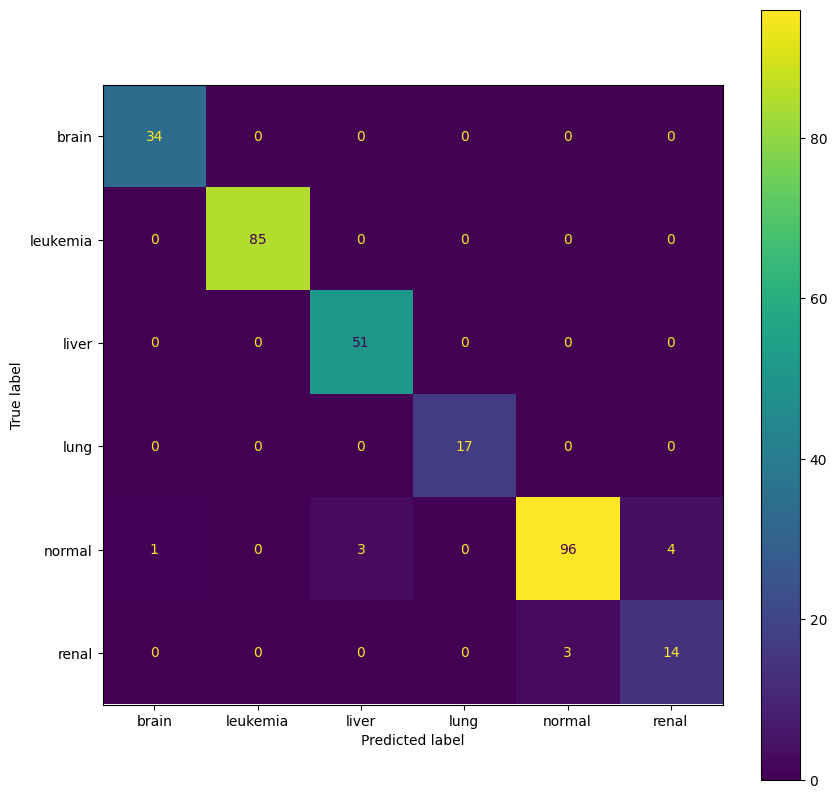

In [10]:
# Izračun točnosti modela

accuracy = sm.accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

# Određivanje matrice zabune modela

cm = sm.confusion_matrix(y_test, y_pred)
disp = sm.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
figp = disp.figure_
figp.set_figwidth(10)
figp.set_figheight(10)

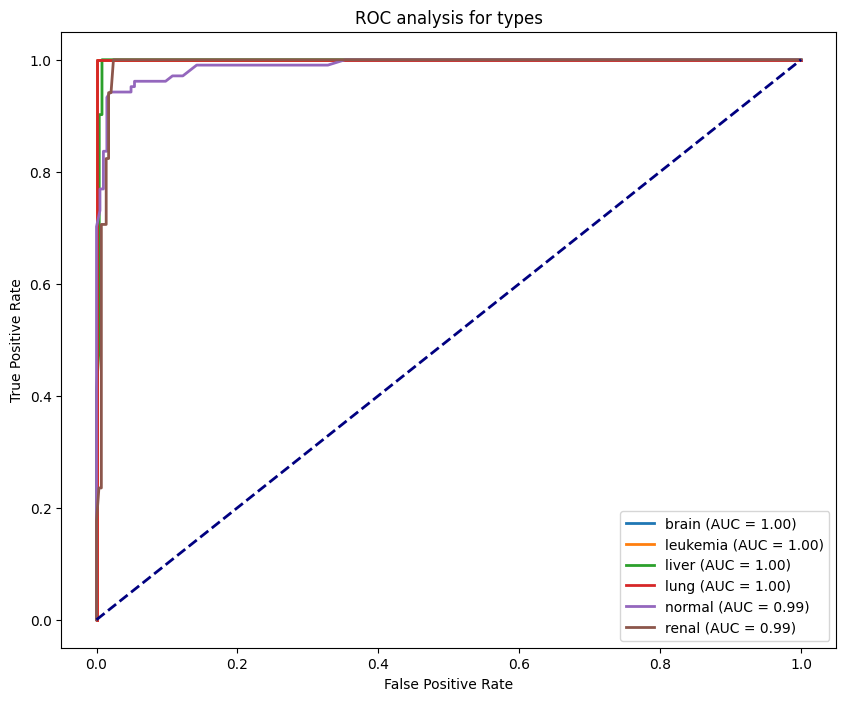

In [6]:
# ROC analiza modela

overtypes = [i for i in np.unique(df1["overtype"])]

y2_pred = model.predict_proba(X_test)
y_test_binar = sp.label_binarize(y_test, classes=np.unique(y_test))

pyplt.figure(figsize=(10, 8))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i, disease_name in enumerate(overtypes):
    fpr[i], tpr[i], _ = sm.roc_curve(y_test_binar[:, i], y2_pred[:, i])
    roc_auc[i] = sm.auc(fpr[i], tpr[i])
    pyplt.plot(fpr[i], tpr[i], lw=2, label=f'{disease_name} (AUC = {roc_auc[i]:.2f})')

pyplt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
pyplt.xlabel('False Positive Rate')
pyplt.ylabel('True Positive Rate')
pyplt.title('ROC analysis for types')
pyplt.legend(loc="lower right")
pyplt.show()

MODEL RandomForest ZA ODREĐIVANJE TIPA TUMORA NA TEMELJU GENETSKE AKTIVNOSTI

In [15]:
Z = df_type.drop("type", axis=1)
w = df_type["type"]

# Određivanje skupova za treniranje i testiranje

Z_train, Z_test, w_train, w_test = sms.train_test_split(Z, w, test_size=0.3, random_state=42)

# Izrada modela na temelju algoritma slučajne šume

model2 = se.RandomForestClassifier(random_state=42)
model2.fit(Z_train, w_train)
w_pred = model2.predict(Z_test)

Accuracy:  0.9025974025974026


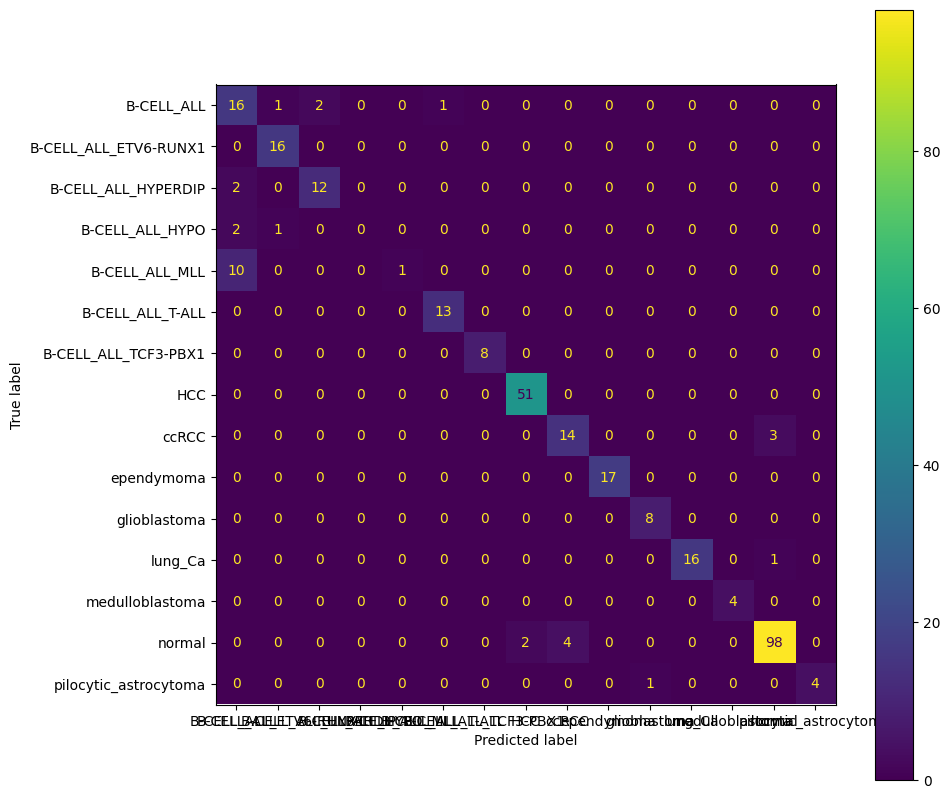

In [16]:
# Izračun točnosti modela

accuracy2 = sm.accuracy_score(w_test, w_pred)
print("Accuracy: ", accuracy2)

# Određivanje matrice zabune modela

cm2 = sm.confusion_matrix(w_test, w_pred)
disp2 = sm.ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=model2.classes_)
disp2.plot()
fig = disp2.figure_
fig.set_figwidth(10)
fig.set_figheight(10)

MODEL XGBoost ZA ODREĐIVANJE NADTIPA I TIPA TUMORA NA TEMELJU GENETSKE AKTIVNOSTI

Accuracy:  0.9512987012987013


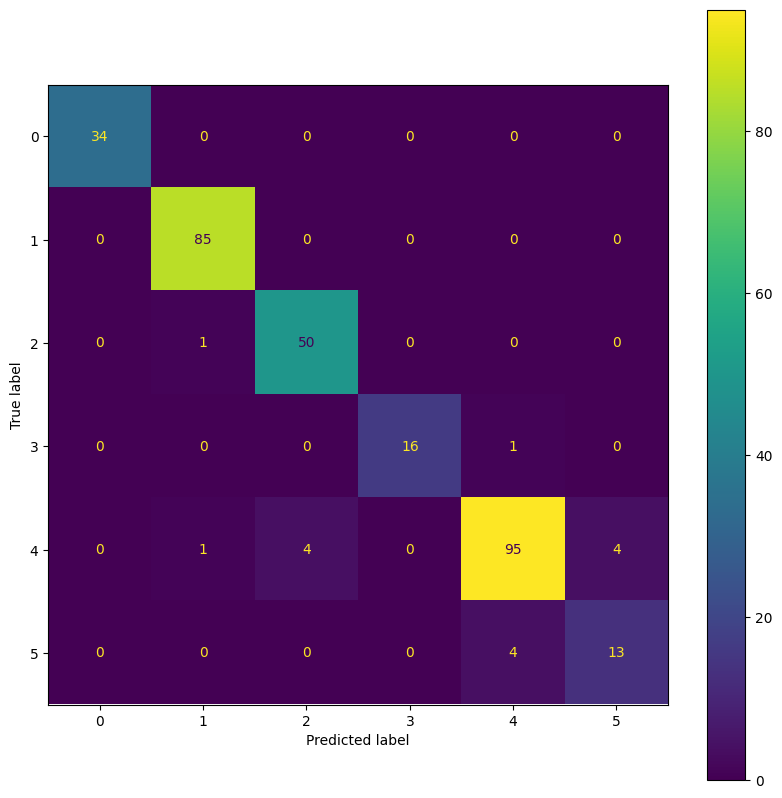

In [17]:
# Pretvorba klasa u kategoričke klase radi XGBoost utilizacije

model3 = xgb.XGBClassifier()
le = sp.LabelEncoder()
y2_train = le.fit_transform(y_train)
model3.fit(X_train, y2_train)

# Treniranje i evaluacija modela

y2_pred = model3.predict(X_test)
y2_pred = le.fit_transform(y2_pred)

y2_test = le.fit_transform(y_test)

accuracy3 = sm.accuracy_score(y2_test, y2_pred)
print("Accuracy: ", accuracy3)

cm3 = sm.confusion_matrix(y2_test, y2_pred)
disp3 = sm.ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=model3.classes_)
disp3.plot()
fig3 = disp3.figure_
fig3.set_figwidth(10)
fig3.set_figheight(10)

Accuracy:  0.8928571428571429


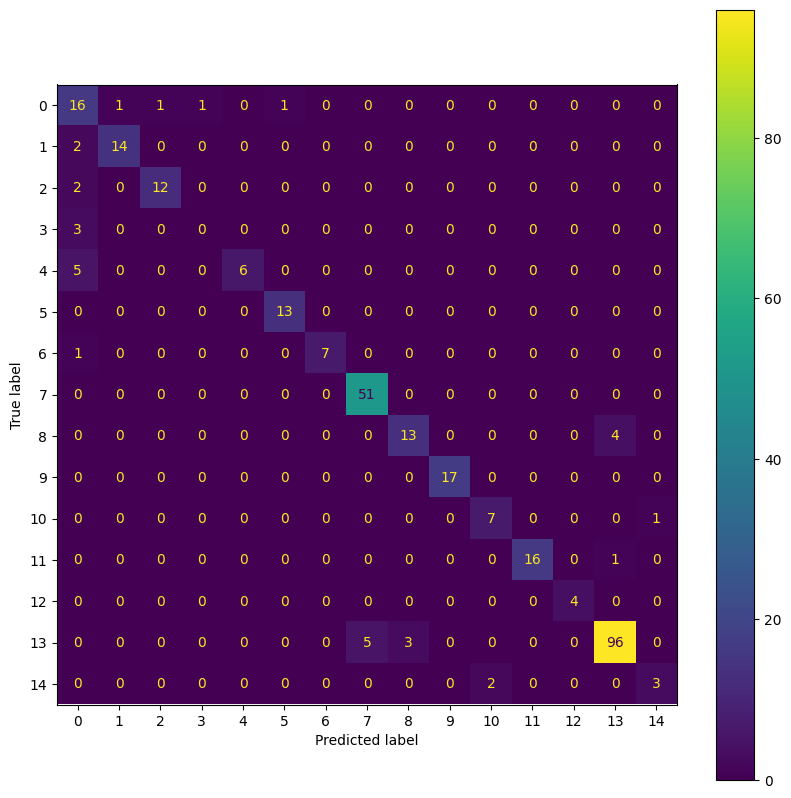

In [18]:
# Pretvorba klasa u kategoričke klase radi XGBoost utilizacije

model4 = xgb.XGBClassifier()
le2 = sp.LabelEncoder()
w2_train = le2.fit_transform(w_train)
model4.fit(Z_train, w2_train)

# Treniranje i evaluacija modela

w2_pred = model4.predict(Z_test)
w2_pred = le2.fit_transform(w2_pred)

w2_test = le2.fit_transform(w_test)

accuracy4 = sm.accuracy_score(w2_test, w2_pred)
print("Accuracy: ", accuracy4)

cm4 = sm.confusion_matrix(w2_test, w2_pred)
disp4 = sm.ConfusionMatrixDisplay(confusion_matrix=cm4, display_labels=model4.classes_)
disp4.plot()
fig2 = disp4.figure_
fig2.set_figwidth(10)
fig2.set_figheight(10)

ODREĐIVANJE SIGNIFIKANTNIH ZNAČAJKI ZA SVAKI NADTIP

In [14]:
# Definicija funkcije za feature extraction

def important_features_fuction(overtype_string):

    # Dataset za binarnu klasifikaciju

    df_ren = df1.copy()
    df_ren = df_ren.drop("type", axis=1)
    df_ren = df_ren.drop("samples", axis=1)
    df_ren["overtype"] = np.where(df_ren["overtype"] != overtype_string, "other", overtype_string)

    Ren_X = df_ren.drop("overtype", axis=1)
    Ren_y = df_ren["overtype"]

    # Korištenje F-Classifier za određivanje važnosti značajki

    Ren_ft = fs.SelectKBest(fs.f_classif, k=50).fit(Ren_X, Ren_y)
    Ren_inds = Ren_ft.get_support(indices=True)
    Ren_feature_list = Ren_X.iloc[:, Ren_inds].columns

    df_ren_features = pd.DataFrame(Ren_feature_list)
    df_ren_features.rename(columns = {0:"Marker"}, inplace = True)
    df_ren_features["Organ"] = overtype_string

    # Korištenje MutualInfoClassifier (InfoGain) za određivanje važnosti značajki

    Ren_ft = fs.SelectKBest(fs.mutual_info_classif, k=50).fit(Ren_X, Ren_y)
    Ren_inds = Ren_ft.get_support(indices=True)
    Ren_feature_list = Ren_X.iloc[:, Ren_inds].columns

    df_ren_features2 = pd.DataFrame(Ren_feature_list)
    df_ren_features2.rename(columns = {0:"Marker"}, inplace = True)
    df_ren_features2["Organ"] = overtype_string

    # Korištenje ExtraTreesClassifier za određivanje važnosti značajki

    ETC = se.ExtraTreesClassifier(n_estimators=500, random_state=42).fit(Ren_X, Ren_y)
    Ren_importances = ETC.feature_importances_

    Ren_matrix = []

    for i in range (Ren_X.shape[1]):
        Ren_matrix.append([i, Ren_importances[i]])

    Ren_importances.sort()
    Ren_greatest_importances = Ren_importances[Ren_X.shape[1]:Ren_X.shape[1]-51:-1]

    Ren_features = []

    for i in range (Ren_X.shape[1]):
        if(Ren_matrix[i][1] in Ren_greatest_importances):
            Ren_features.append([Ren_X.columns[Ren_matrix[i][0]], Ren_matrix[i][1]])

    df_ren_features3 = pd.DataFrame(Ren_features)
    df_ren_features3.rename(columns = {0:"Marker", 1:"Importance"}, inplace = True)
    df_ren_features3 = df_ren_features3.drop("Importance", axis=1)
    df_ren_features3["Organ"] = overtype_string

    df_ren_featuresint1 = pd.merge(df_ren_features, df_ren_features2, how="inner", on=["Marker", "Organ"])
    df_ren_featuresint2 = pd.merge(df_ren_features, df_ren_features3, how="inner", on=["Marker", "Organ"])
    df_ren_featuresint3 = pd.merge(df_ren_features2, df_ren_features3, how="inner", on=["Marker", "Organ"])

    df_ren_features_fin = pd.DataFrame()
    df_ren_features_fin = pd.concat([df_ren_featuresint1, df_ren_featuresint2, df_ren_featuresint3], join="inner", axis=0).drop_duplicates(keep="first").head(10)
    df_ren_features_fin = df_ren_features_fin.reset_index(drop=True)
    
    display(df_ren_features_fin)
    return df_ren_features_fin

# Selekcija značajki svake klase pomoću funkcije

DF_features = pd.DataFrame()
DF_features = pd.concat([important_features_fuction("liver"), important_features_fuction("leukemia"), important_features_fuction("lung"), important_features_fuction("renal"), important_features_fuction("brain")], join="inner", axis=0)
DF_features = DF_features.reset_index(drop=True)

# Određivanje prosječne razine ekspresije za svaku značajku ukupno i za dani organ

DF_features["Avg. expression"] = 0.0

for i in range(50):
    DF_features.at[i, "Avg. expression"] = (df1.loc[df1["overtype"] == DF_features.iloc[i]["Organ"], DF_features.iloc[i]["Marker"]]).mean()

display(DF_features)

DF_features.to_csv("selected_features.csv", index=False)

,Marker,Organ
0,204046_at,liver
1,207667_s_at,liver
2,209365_s_at,liver
3,215178_x_at,liver
4,215712_s_at,liver
5,204018_x_at,liver
6,209889_at,liver
7,211166_at,liver
8,211745_x_at,liver
9,211768_at,liver


,Marker,Organ
0,217757_at,leukemia
1,221767_x_at,leukemia
2,221802_s_at,leukemia
3,201876_at,leukemia
4,202054_s_at,leukemia
5,202090_s_at,leukemia
6,202842_s_at,leukemia
7,203382_s_at,leukemia
8,207335_x_at,leukemia
9,208791_at,leukemia


,Marker,Organ
0,203757_s_at,lung
1,205941_s_at,lung
2,209173_at,lung
3,210608_s_at,lung
4,211657_at,lung
5,217428_s_at,lung
6,218186_at,lung
7,218960_at,lung
8,219388_at,lung
9,37004_at,lung


,Marker,Organ
0,205532_s_at,renal
1,205799_s_at,renal
2,206228_at,renal
3,207470_at,renal
4,210735_s_at,renal
5,215392_at,renal
6,219271_at,renal
7,219621_at,renal
8,221009_s_at,renal
9,222281_s_at,renal


,Marker,Organ
0,204966_at,brain
1,203540_at,brain
2,205493_s_at,brain
3,211842_s_at,brain
4,212843_at,brain
5,214393_at,brain
6,214772_at,brain
7,216225_at,brain
8,217366_at,brain
9,220278_at,brain


,Marker,Organ,Avg. expression
0,204046_at,liver,4.099419
1,207667_s_at,liver,4.850295
2,209365_s_at,liver,5.210791
3,215178_x_at,liver,4.124936
4,215712_s_at,liver,4.102644
5,204018_x_at,liver,7.139014
6,209889_at,liver,4.354145
7,211166_at,liver,3.962704
8,211745_x_at,liver,7.405071
9,211768_at,liver,3.919866


MULTIKLASIFIKATOR ZA PODTIPOVE LEUKEMIJE I PODTIPOVE MOŽDANIH TUMORA

Accuracy:  0.8588235294117647


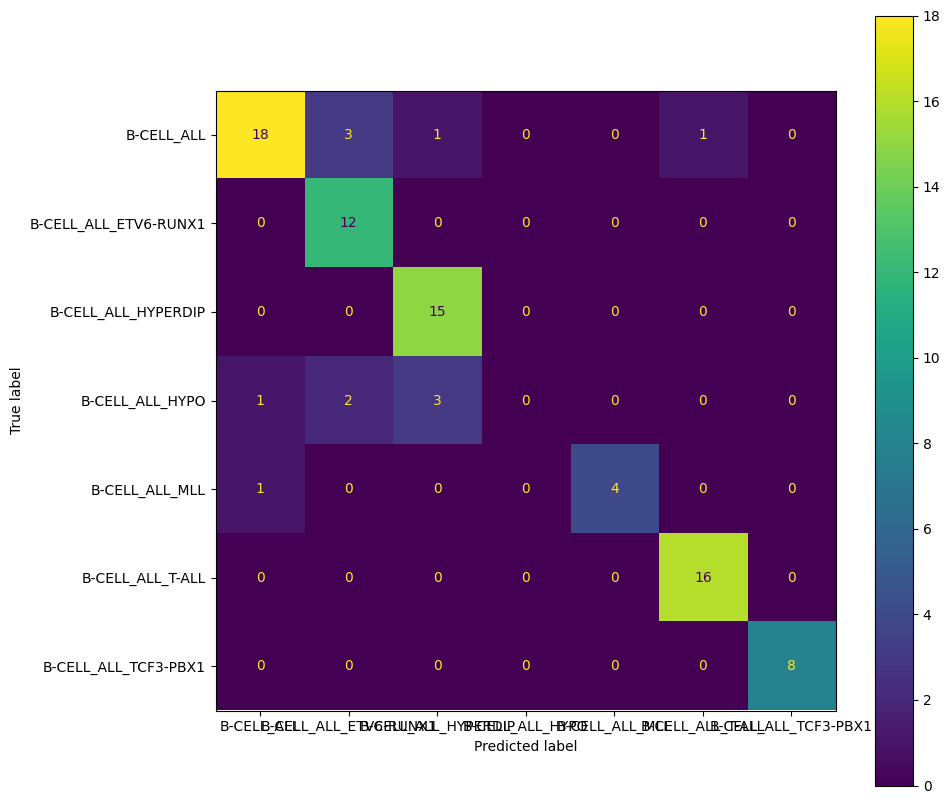

In [30]:
#RFC za podtipove leukemije

df_leukemia2 = pd.read_csv("Databases/Leukemia_GSE28497.csv")
df_leukemia2 = df_leukemia2.drop("samples", axis=1)
X_leuk = df_leukemia2.drop("type", axis=1)
y_leuk = df_leukemia2["type"]

X_train_leuk, X_test_leuk, y_train_leuk, y_test_leuk = sms.train_test_split(X_leuk, y_leuk, test_size=0.3, random_state=42)

model_leuk = se.RandomForestClassifier(n_estimators=200, random_state=42)
model_leuk.fit(X_train_leuk, y_train_leuk)
y_pred_leuk = model_leuk.predict(X_test_leuk)

accuracy = sm.accuracy_score(y_test_leuk, y_pred_leuk)
print("Accuracy: ", accuracy)

cm = sm.confusion_matrix(y_test_leuk, y_pred_leuk)
disp = sm.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_leuk.classes_)
disp.plot()
fig = disp.figure_
fig.set_figwidth(10)
fig.set_figheight(10)

Accuracy:  0.8974358974358975


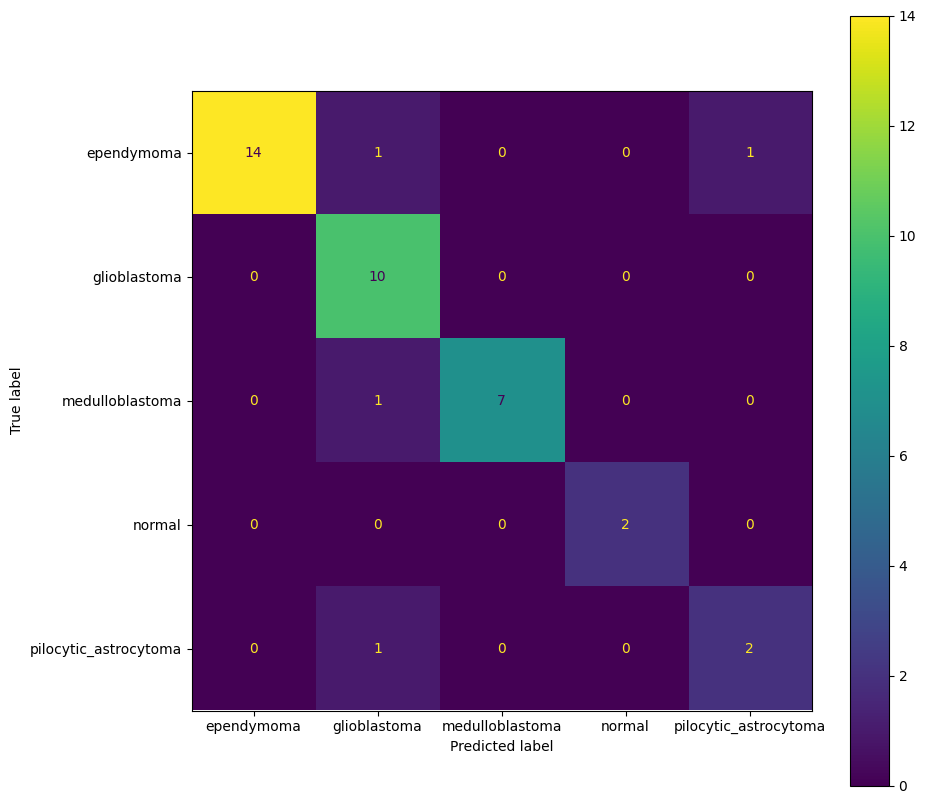

In [31]:
#RFC za podtipove tumora mozga

df_brain2 = pd.read_csv("Databases/Brain_GSE50161.csv")
df_brain2 = df_brain2.drop("samples", axis=1)
X_brain = df_brain2.drop("type", axis=1)
y_brain = df_brain2["type"]

X_train_brain, X_test_brain, y_train_brain, y_test_brain = sms.train_test_split(X_brain, y_brain, test_size=0.3, random_state=42)

model_brain = se.RandomForestClassifier(n_estimators=200, random_state=42)
model_brain.fit(X_train_brain, y_train_brain)
y_pred_brain = model_brain.predict(X_test_brain)

accuracy = sm.accuracy_score(y_test_brain, y_pred_brain)
print("Accuracy: ", accuracy)

cm = sm.confusion_matrix(y_test_brain, y_pred_brain)
disp = sm.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_brain.classes_)
disp.plot()
fig = disp.figure_
fig.set_figwidth(10)
fig.set_figheight(10)